In [33]:
# Importar as bibliotecas necessárias
import os
import time
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchmetrics
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

# Verificar se CUDA está disponível e definir o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Definir as cores para as classes
CLASS_COLORS = { 
    'Doenca': (255, 0, 0), 
    'Saudavel': (0, 255, 0), 
    'Solo': (0, 0, 255) 
}

Usando o dispositivo: cuda


In [34]:
# Classe do Dataset personalizado
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Modificar a extensão da máscara para '.png'
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Carregar a imagem e a máscara
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        
        if self.transform:
            # Aplicar transformações, se houver
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Convertemos as máscaras de imagem em um array de índices de classe
        mask = self.mask_to_class(mask)
        
        return image, mask
    
    def mask_to_class(self, mask):
        # Converte a máscara para um array NumPy e ajusta para escala de 0 a 255
        mask_array = (np.array(mask, dtype=np.float32) * 255).astype(np.uint8)

        # Garantir que esté em [H, W, C]
        if mask_array.shape[0] == 3:
            mask_array = mask_array.transpose(1, 2, 0)

        mask_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.int64)

        for i, color in enumerate(CLASS_COLORS.values()):
            # Realizar comparação e detecção de igualdade entre pixels
            equal_color = np.all(mask_array == color, axis=-1)
            mask_indices[equal_color] = i

        return torch.tensor(mask_indices, dtype=torch.long)

# Testar a primeira amostra do dataset para verificar as classes convertidas da máscara
image, mask = sample_dataset[0]

# Outras inicializações de datasets e dataloaders
train_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Train",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Train",
    transform=get_transforms()
)

val_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Val",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Val",
    transform=get_transforms()
)

test_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Test",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Test",
    transform=get_transforms()
)

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print("Dados carregados e preparados.")

Valores únicos nas máscaras logo após carregar: [[  0   0   0]
 [  0   0   1]
 [  0   0   2]
 ...
 [253   0   0]
 [254   0   0]
 [255   0   0]]
Checando para cor RGB: (255, 0, 0)
Pixels identificados como (255, 0, 0): 5134
Checando para cor RGB: (0, 255, 0)
Pixels identificados como (0, 255, 0): 11529
Checando para cor RGB: (0, 0, 255)
Pixels identificados como (0, 0, 255): 22063
Classes únicas encontradas após conversão: [0 1 2]
Dados carregados e preparados.


In [35]:
# Importar a biblioteca segmentation-models-pytorch
!pip install segmentation-models-pytorch --quiet

import segmentation_models_pytorch as smp

# Inicializar as arquiteturas dos modelos com os pesos pretreinados por padrão
unet = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
pspnet = smp.PSPNet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
linknet = smp.Linknet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
deeplabv3 = smp.DeepLabV3(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)

models = {
    'U-Net': unet,
    'PSPNet': pspnet,
    'LinkNet': linknet,
    'DeepLabV3': deeplabv3
}

print("Modelos configurados e prontos para treinamento.")

Modelos configurados e prontos para treinamento.


In [36]:
# Importar métricas do torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score, MulticlassPrecision
from torchmetrics import JaccardIndex

# Configuração da função de perda e otimizadores
criterion = nn.CrossEntropyLoss()  # Considerando que temos múltiplas classes
learning_rate = 0.001
num_epochs = 10 # Número máximo de épocas
patience = 30  # Número de épocas sem melhora para interromper o treinamento antecipadamente

# Configurar as métricas
metrics = {
    'F1': MulticlassF1Score(num_classes=len(CLASS_COLORS)).to(device),
    'Jaccard': MulticlassJaccardIndex(num_classes=len(CLASS_COLORS)).to(device),
    'Precision': MulticlassPrecision(num_classes=len(CLASS_COLORS)).to(device),
    # Implementar AJI e Dice se necessário
}


def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, metrics, num_epochs, device, patience):
    since = time.time()
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_metrics = {key: 0 for key in metrics.keys()}
            
            for inputs, masks in tqdm(data_loader):
                inputs, masks = inputs.to(device), masks.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                for metric_name, metric in metrics.items():
                    running_metrics[metric_name] += metric(preds, masks).item() * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_metrics = {key: value / len(data_loader.dataset) for key, value in running_metrics.items()}

            print(f'{phase} Loss: {epoch_loss:.4f}')
            for metric_name in metrics:
                print(f'{phase} {metric_name}: {epoch_metrics[metric_name]:.4f}')

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        print(f'Patience counter: {patience_counter}')

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)
    return model

# Definir um otimizador para cada modelo
optimizers = {
    model_name: torch.optim.Adam(model.parameters(), lr=learning_rate) 
    for model_name, model in models.items()
}

# Continue com o Treinamento dos Modelos
for model_name, model in models.items():
    print(f"Treinando {model_name} com early stopping...")
    trained_model = train_model_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizers[model_name],
        metrics=metrics,
        num_epochs=num_epochs,
        device=device,
        patience=patience
    )
    torch.save(trained_model.state_dict(), f'{model_name}_best.pth')
    print(f'{model_name} treinado e salvo com sucesso.\n')

print("Treinamento completo de todos os modelos com early stopping.")

Treinando U-Net com early stopping...
Epoch 1/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.18it/s]


train Loss: 0.8693
train F1: 0.5679
train Jaccard: 0.4196
train Precision: 0.6167


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 13.8634
val F1: 0.3146
val Jaccard: 0.2140
val Precision: 0.4536
Patience counter: 0
Epoch 2/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


train Loss: 0.5454
train F1: 0.7163
train Jaccard: 0.5856
train Precision: 0.7512


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 0.6685
val F1: 0.6541
val Jaccard: 0.5235
val Precision: 0.6979
Patience counter: 0
Epoch 3/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.5102
train F1: 0.7451
train Jaccard: 0.6136
train Precision: 0.7671


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.6078
val F1: 0.6683
val Jaccard: 0.5479
val Precision: 0.7056
Patience counter: 0
Epoch 4/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


train Loss: 0.4904
train F1: 0.7540
train Jaccard: 0.6258
train Precision: 0.7725


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 0.4900
val F1: 0.6728
val Jaccard: 0.5591
val Precision: 0.6911
Patience counter: 0
Epoch 5/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


train Loss: 0.4091
train F1: 0.8047
train Jaccard: 0.6868
train Precision: 0.8300


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


val Loss: 0.8173
val F1: 0.5292
val Jaccard: 0.4334
val Precision: 0.6074
Patience counter: 1
Epoch 6/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


train Loss: 0.3924
train F1: 0.8168
train Jaccard: 0.7034
train Precision: 0.8201


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


val Loss: 0.4687
val F1: 0.6648
val Jaccard: 0.5644
val Precision: 0.6936
Patience counter: 0
Epoch 7/10
----------


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


train Loss: 0.3508
train F1: 0.8480
train Jaccard: 0.7451
train Precision: 0.8471


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


val Loss: 0.6853
val F1: 0.6792
val Jaccard: 0.5454
val Precision: 0.7172
Patience counter: 1
Epoch 8/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


train Loss: 0.3534
train F1: 0.8422
train Jaccard: 0.7398
train Precision: 0.8482


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 0.7213
val F1: 0.6176
val Jaccard: 0.5422
val Precision: 0.5943
Patience counter: 2
Epoch 9/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


train Loss: 0.3597
train F1: 0.8342
train Jaccard: 0.7248
train Precision: 0.8371


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


val Loss: 0.8400
val F1: 0.6667
val Jaccard: 0.5468
val Precision: 0.7111
Patience counter: 3
Epoch 10/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


train Loss: 0.3302
train F1: 0.8512
train Jaccard: 0.7502
train Precision: 0.8505


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 0.6526
val F1: 0.6649
val Jaccard: 0.5404
val Precision: 0.7308
Patience counter: 4
Training complete in 4m 14s
Best val loss: 0.4687
U-Net treinado e salvo com sucesso.

Treinando PSPNet com early stopping...
Epoch 1/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.7791
train F1: 0.5762
train Jaccard: 0.4498
train Precision: 0.6400


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 2.7694
val F1: 0.2449
val Jaccard: 0.1734
val Precision: 0.4424
Patience counter: 0
Epoch 2/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.6923
train F1: 0.6417
train Jaccard: 0.5006
train Precision: 0.6811


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.8615
val F1: 0.5712
val Jaccard: 0.4303
val Precision: 0.6456
Patience counter: 0
Epoch 3/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.4853
train F1: 0.7376
train Jaccard: 0.6120
train Precision: 0.7554


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 0.8703
val F1: 0.5940
val Jaccard: 0.5057
val Precision: 0.6364
Patience counter: 1
Epoch 4/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


train Loss: 0.5135
train F1: 0.7575
train Jaccard: 0.6254
train Precision: 0.7782


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.6538
val F1: 0.6134
val Jaccard: 0.5217
val Precision: 0.7116
Patience counter: 0
Epoch 5/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


train Loss: 0.4210
train F1: 0.7853
train Jaccard: 0.6666
train Precision: 0.8049


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 0.5199
val F1: 0.6848
val Jaccard: 0.5600
val Precision: 0.7046
Patience counter: 0
Epoch 6/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


train Loss: 0.4094
train F1: 0.7910
train Jaccard: 0.6749
train Precision: 0.8139


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 1.0845
val F1: 0.6737
val Jaccard: 0.5776
val Precision: 0.7132
Patience counter: 1
Epoch 7/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.3439
train F1: 0.8293
train Jaccard: 0.7196
train Precision: 0.8364


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


val Loss: 0.6040
val F1: 0.6470
val Jaccard: 0.5158
val Precision: 0.6808
Patience counter: 2
Epoch 8/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.2879
train F1: 0.8673
train Jaccard: 0.7728
train Precision: 0.8647


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


val Loss: 0.5620
val F1: 0.7216
val Jaccard: 0.6010
val Precision: 0.8147
Patience counter: 3
Epoch 9/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.2598
train F1: 0.8810
train Jaccard: 0.7922
train Precision: 0.8818


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


val Loss: 0.5264
val F1: 0.7501
val Jaccard: 0.6305
val Precision: 0.7535
Patience counter: 4
Epoch 10/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


train Loss: 0.2356
train F1: 0.8959
train Jaccard: 0.8150
train Precision: 0.8963


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 0.5427
val F1: 0.6926
val Jaccard: 0.5910
val Precision: 0.7489
Patience counter: 5
Training complete in 4m 3s
Best val loss: 0.5199
PSPNet treinado e salvo com sucesso.

Treinando LinkNet com early stopping...
Epoch 1/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.8572
train F1: 0.5044
train Jaccard: 0.3755
train Precision: 0.5351


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


val Loss: 0.8348
val F1: 0.4643
val Jaccard: 0.3414
val Precision: 0.5451
Patience counter: 0
Epoch 2/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


train Loss: 0.5864
train F1: 0.6304
train Jaccard: 0.5115
train Precision: 0.6734


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 0.5963
val F1: 0.5964
val Jaccard: 0.4880
val Precision: 0.6627
Patience counter: 0
Epoch 3/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


train Loss: 0.5224
train F1: 0.6340
train Jaccard: 0.5283
train Precision: 0.7025


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 0.6175
val F1: 0.6109
val Jaccard: 0.4868
val Precision: 0.6482
Patience counter: 1
Epoch 4/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.4869
train F1: 0.6818
train Jaccard: 0.5674
train Precision: 0.7360


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.4888
val F1: 0.6889
val Jaccard: 0.5649
val Precision: 0.7139
Patience counter: 0
Epoch 5/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.4763
train F1: 0.7318
train Jaccard: 0.6104
train Precision: 0.7439


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 0.4800
val F1: 0.6071
val Jaccard: 0.5347
val Precision: 0.7188
Patience counter: 0
Epoch 6/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


train Loss: 0.4156
train F1: 0.7854
train Jaccard: 0.6707
train Precision: 0.8012


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 0.4762
val F1: 0.6837
val Jaccard: 0.5635
val Precision: 0.6988
Patience counter: 0
Epoch 7/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


train Loss: 0.3997
train F1: 0.8035
train Jaccard: 0.6885
train Precision: 0.8075


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.4192
val F1: 0.7212
val Jaccard: 0.6143
val Precision: 0.7646
Patience counter: 0
Epoch 8/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


train Loss: 0.4122
train F1: 0.7962
train Jaccard: 0.6778
train Precision: 0.7998


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.5176
val F1: 0.6429
val Jaccard: 0.5398
val Precision: 0.7044
Patience counter: 1
Epoch 9/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


train Loss: 0.3842
train F1: 0.8218
train Jaccard: 0.7079
train Precision: 0.8187


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 0.5068
val F1: 0.6798
val Jaccard: 0.5704
val Precision: 0.7349
Patience counter: 2
Epoch 10/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


train Loss: 0.3510
train F1: 0.8386
train Jaccard: 0.7318
train Precision: 0.8371


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


val Loss: 0.6629
val F1: 0.5891
val Jaccard: 0.4571
val Precision: 0.6165
Patience counter: 3
Training complete in 4m 8s
Best val loss: 0.4192
LinkNet treinado e salvo com sucesso.

Treinando DeepLabV3 com early stopping...
Epoch 1/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


train Loss: 0.9067
train F1: 0.5197
train Jaccard: 0.3787
train Precision: 0.5510


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 1.6435
val F1: 0.5032
val Jaccard: 0.3583
val Precision: 0.5230
Patience counter: 0
Epoch 2/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


train Loss: 0.6936
train F1: 0.6222
train Jaccard: 0.4776
train Precision: 0.6559


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


val Loss: 0.8848
val F1: 0.5348
val Jaccard: 0.4168
val Precision: 0.5851
Patience counter: 0
Epoch 3/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


train Loss: 0.6008
train F1: 0.6238
train Jaccard: 0.5032
train Precision: 0.6514


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 0.5296
val F1: 0.6624
val Jaccard: 0.5334
val Precision: 0.6916
Patience counter: 0
Epoch 4/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


train Loss: 0.4947
train F1: 0.7571
train Jaccard: 0.6214
train Precision: 0.7654


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


val Loss: 0.5735
val F1: 0.6705
val Jaccard: 0.5343
val Precision: 0.7062
Patience counter: 1
Epoch 5/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


train Loss: 0.4603
train F1: 0.7774
train Jaccard: 0.6487
train Precision: 0.7784


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


val Loss: 0.5905
val F1: 0.6142
val Jaccard: 0.5344
val Precision: 0.6273
Patience counter: 2
Epoch 6/10
----------


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


train Loss: 0.4770
train F1: 0.7507
train Jaccard: 0.6191
train Precision: 0.7667


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


val Loss: 0.6421
val F1: 0.6451
val Jaccard: 0.5146
val Precision: 0.6856
Patience counter: 3
Epoch 7/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


train Loss: 0.4018
train F1: 0.8105
train Jaccard: 0.6907
train Precision: 0.8092


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


val Loss: 0.4628
val F1: 0.7036
val Jaccard: 0.5911
val Precision: 0.7350
Patience counter: 0
Epoch 8/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.3783
train F1: 0.8162
train Jaccard: 0.7001
train Precision: 0.8188


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


val Loss: 0.4521
val F1: 0.7072
val Jaccard: 0.5981
val Precision: 0.7525
Patience counter: 0
Epoch 9/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


train Loss: 0.3272
train F1: 0.8516
train Jaccard: 0.7483
train Precision: 0.8451


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


val Loss: 0.4279
val F1: 0.7208
val Jaccard: 0.6046
val Precision: 0.7310
Patience counter: 0
Epoch 10/10
----------


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


train Loss: 0.2927
train F1: 0.8628
train Jaccard: 0.7705
train Precision: 0.8637


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]

val Loss: 0.5117
val F1: 0.7166
val Jaccard: 0.5994
val Precision: 0.7247
Patience counter: 1
Training complete in 4m 9s
Best val loss: 0.4279
DeepLabV3 treinado e salvo com sucesso.

Treinamento completo de todos os modelos com early stopping.


C:\Users\Henrique Moreira\AppData\Local\Temp\ipykernel_12208\1315032985.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(f'{mode

Visualizando e salvando predições para U-Net...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


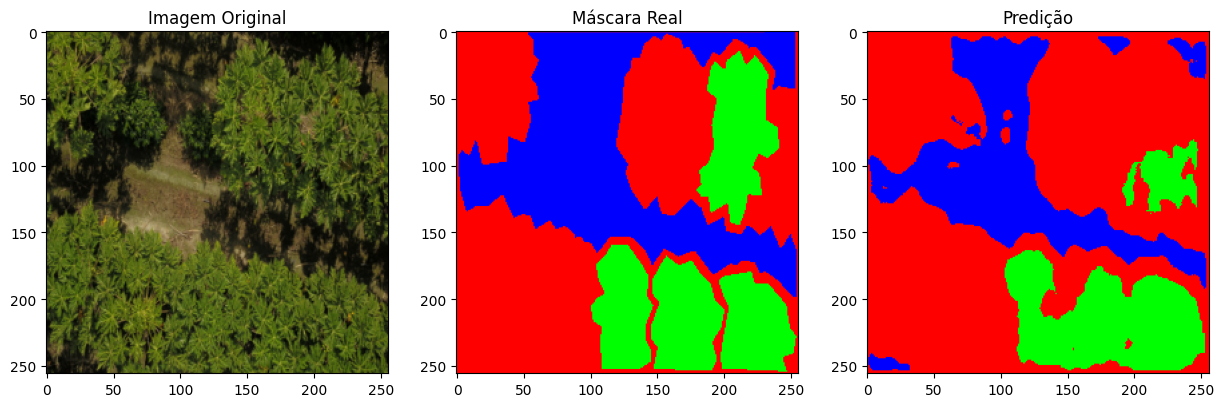

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


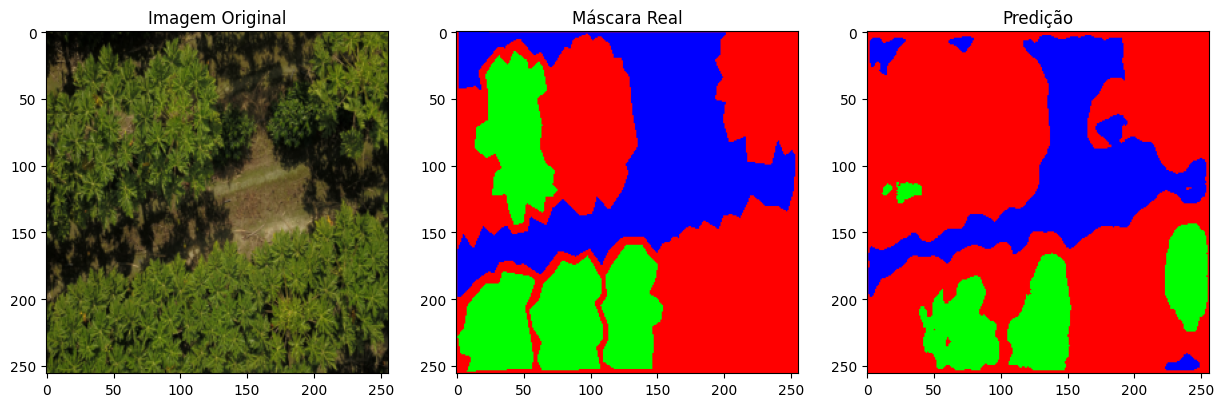

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


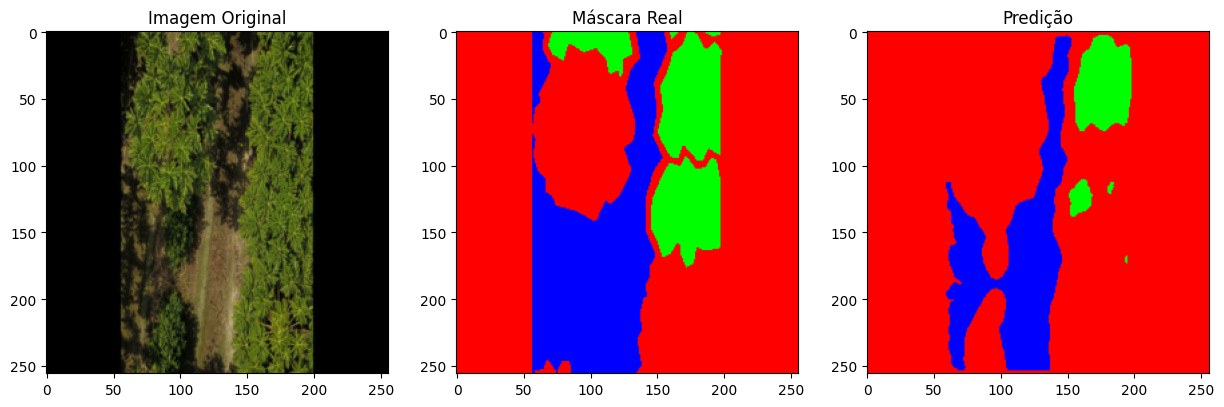

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


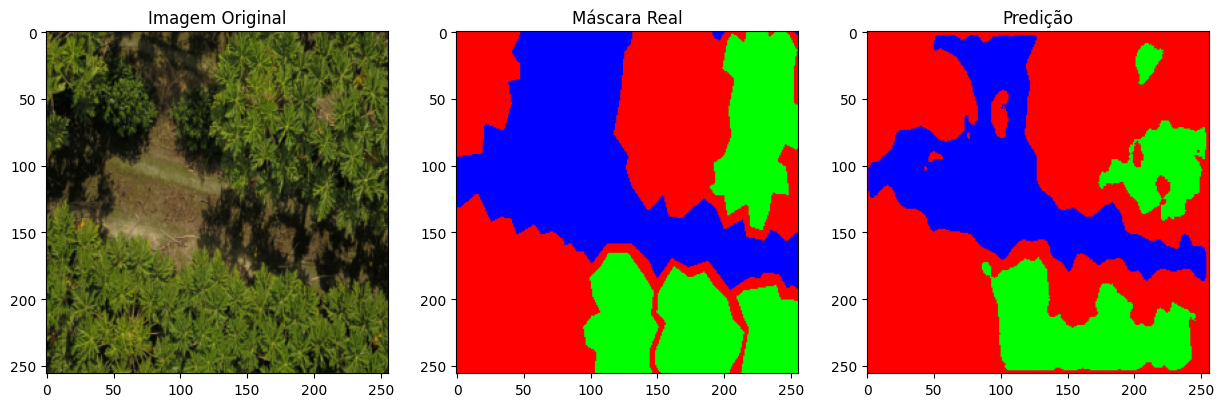

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


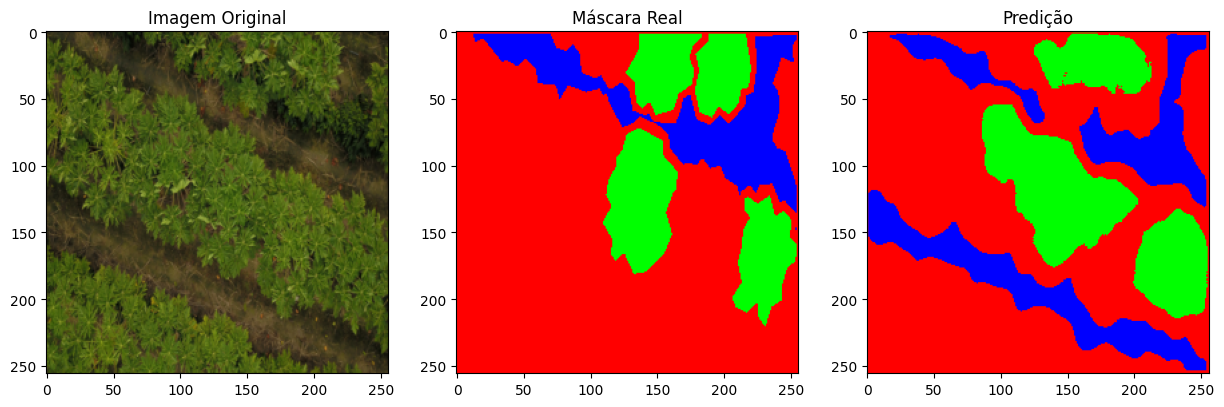

Visualizando e salvando predições para PSPNet...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


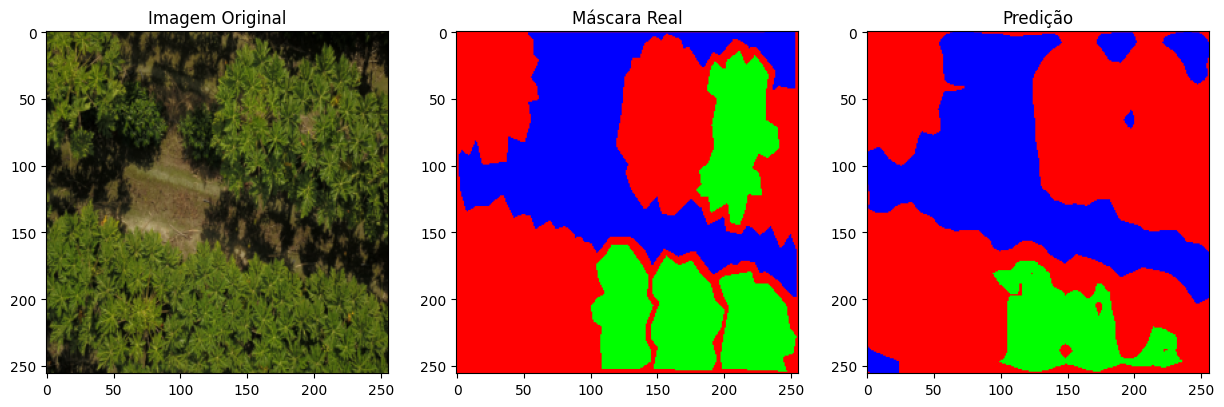

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


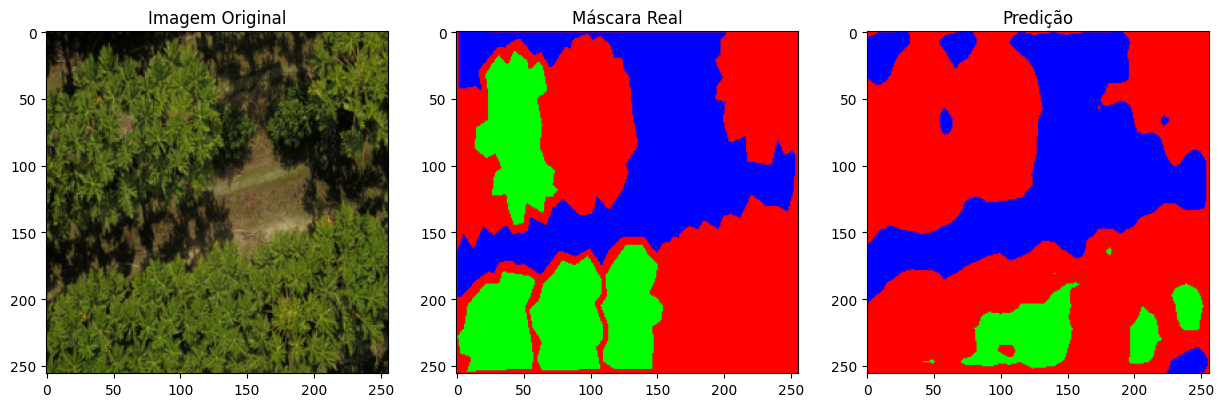

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


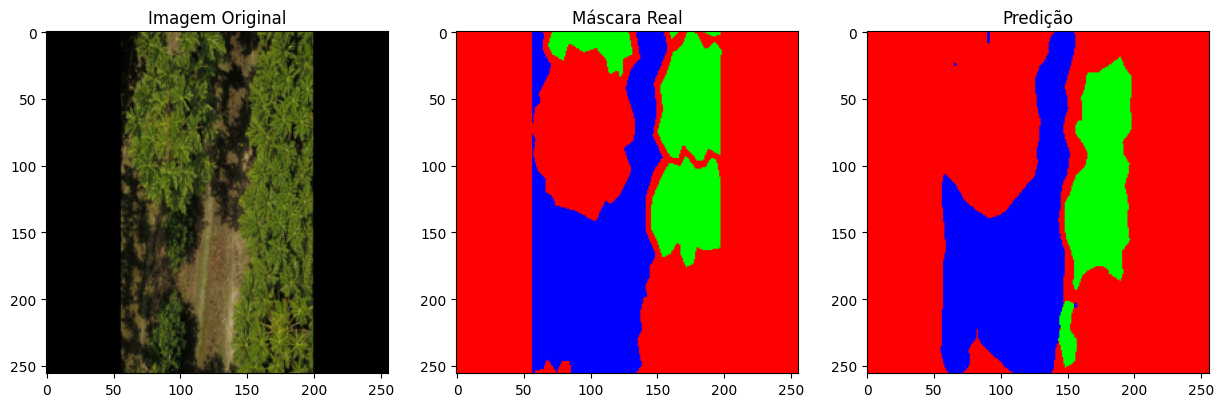

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


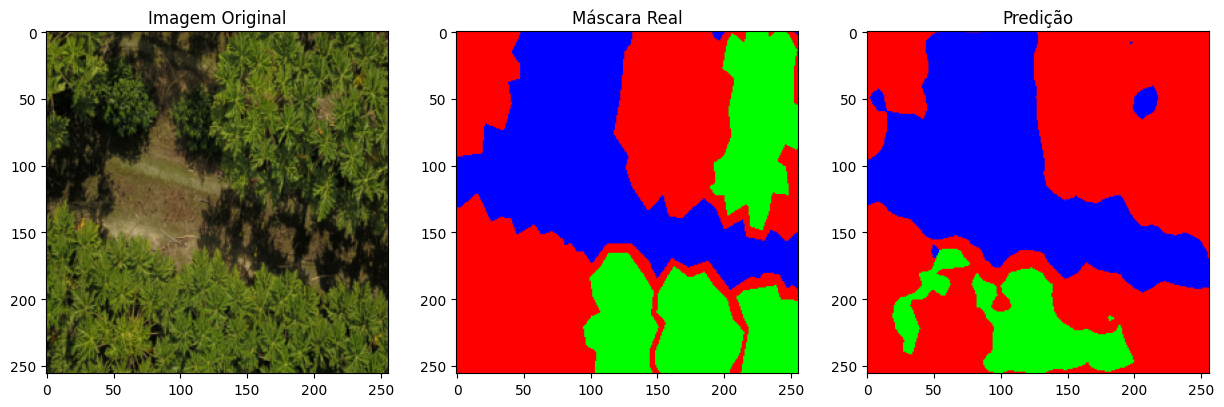

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


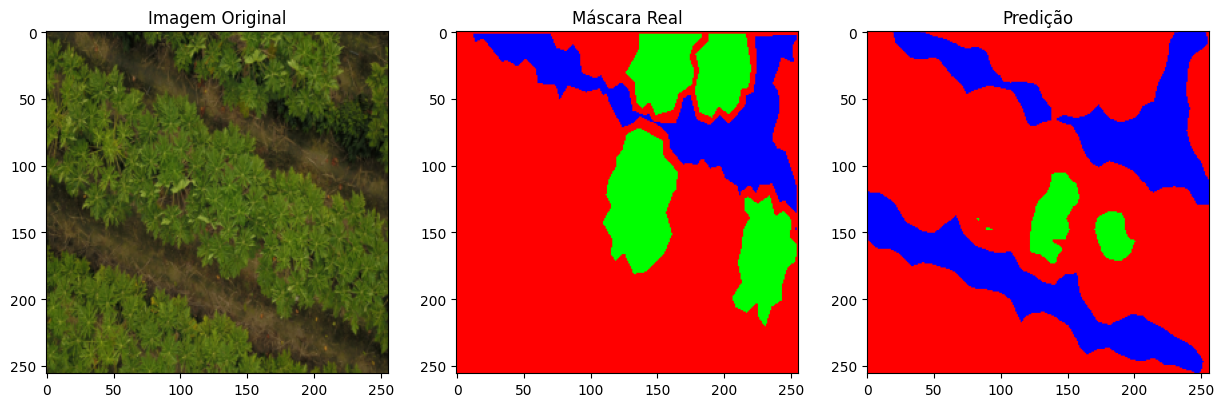

Visualizando e salvando predições para LinkNet...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


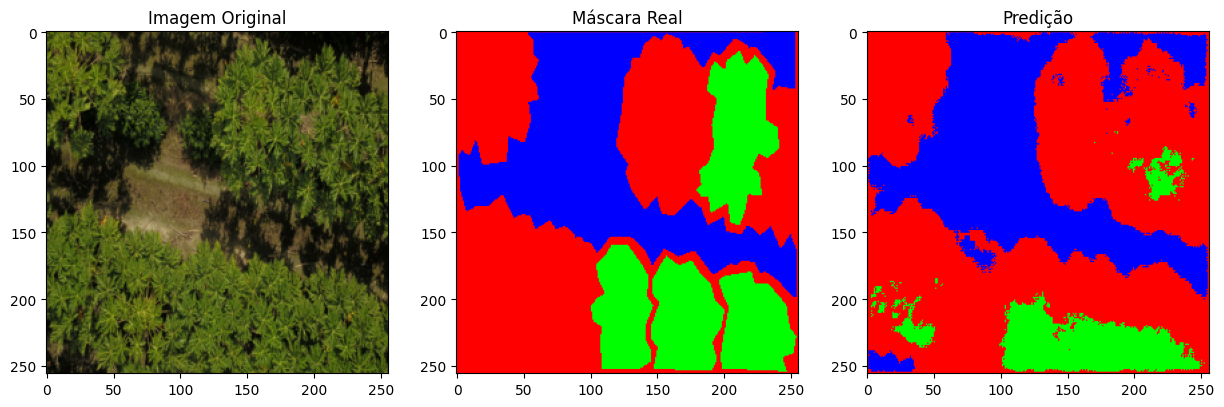

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


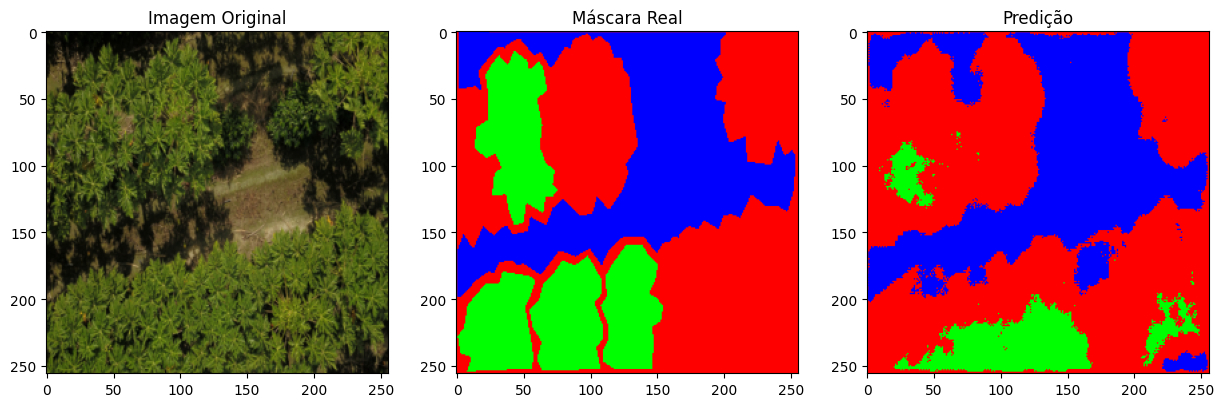

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


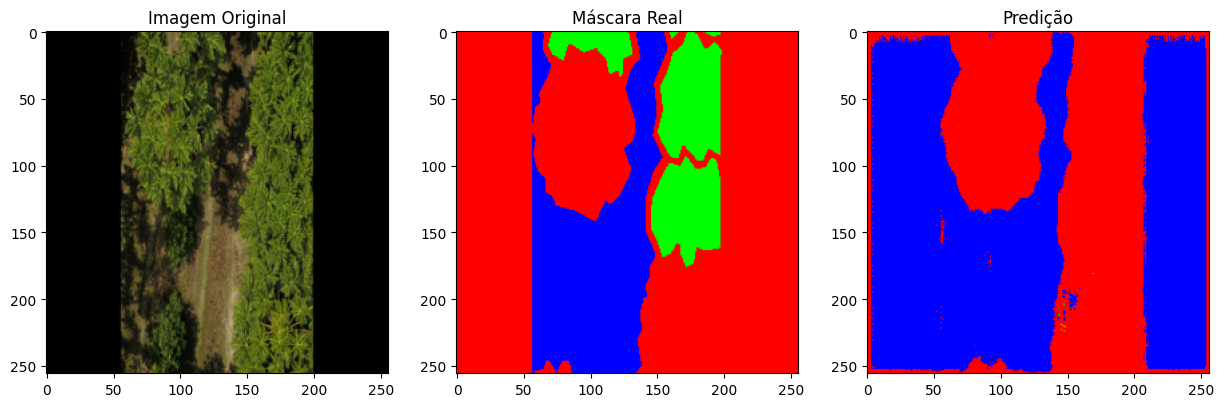

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


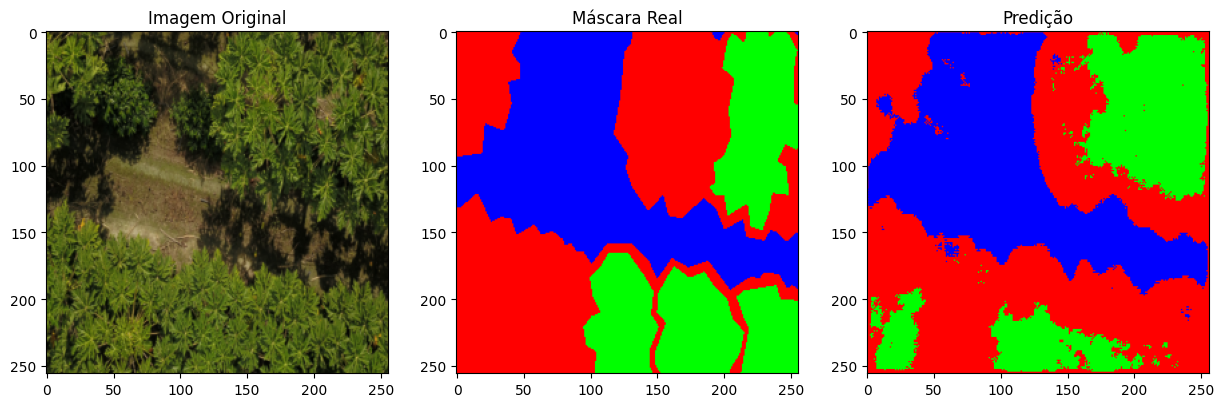

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


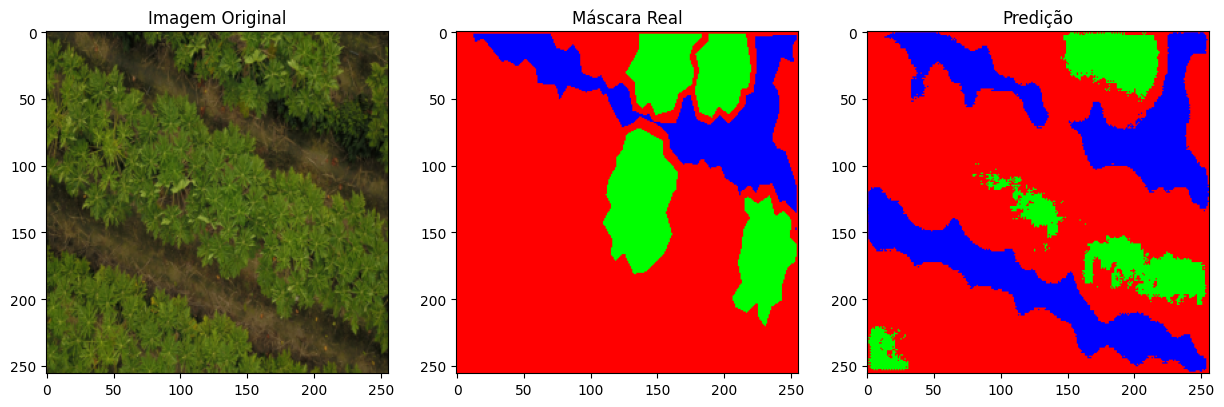

Visualizando e salvando predições para DeepLabV3...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


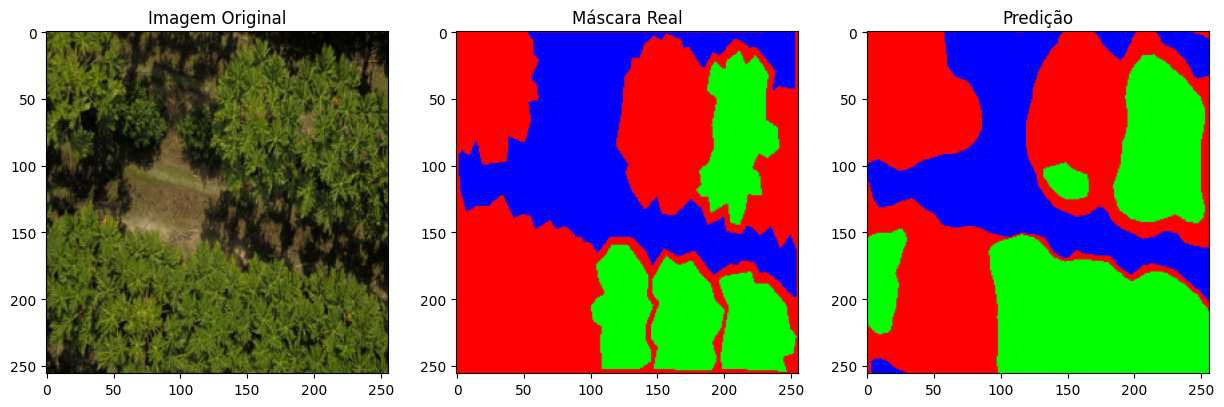

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


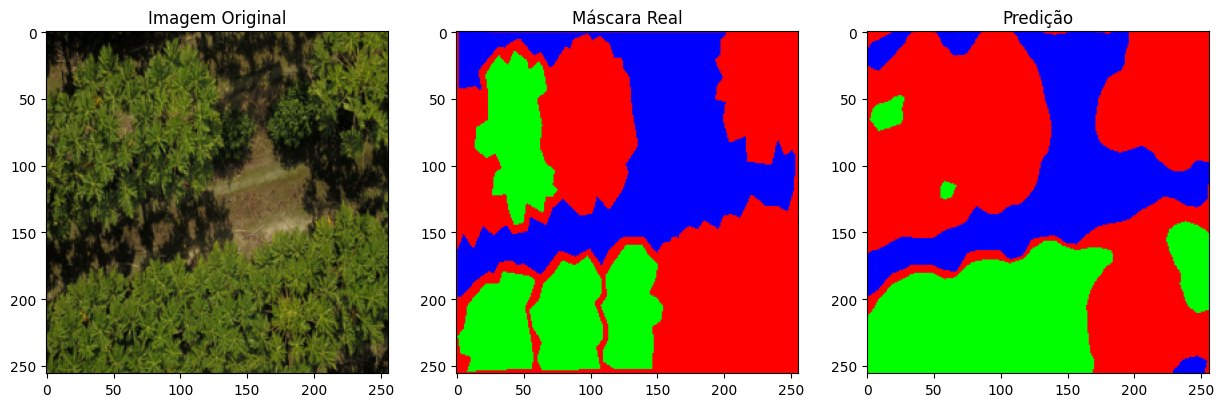

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


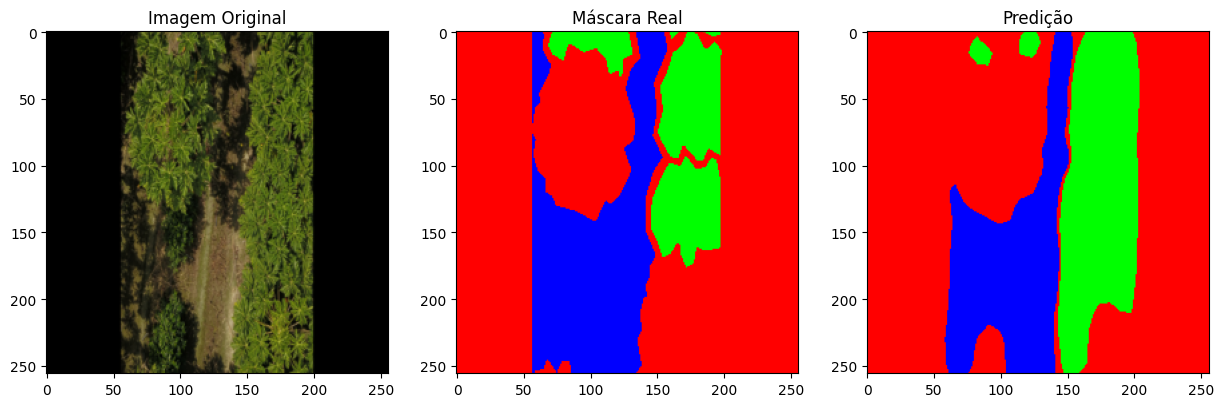

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


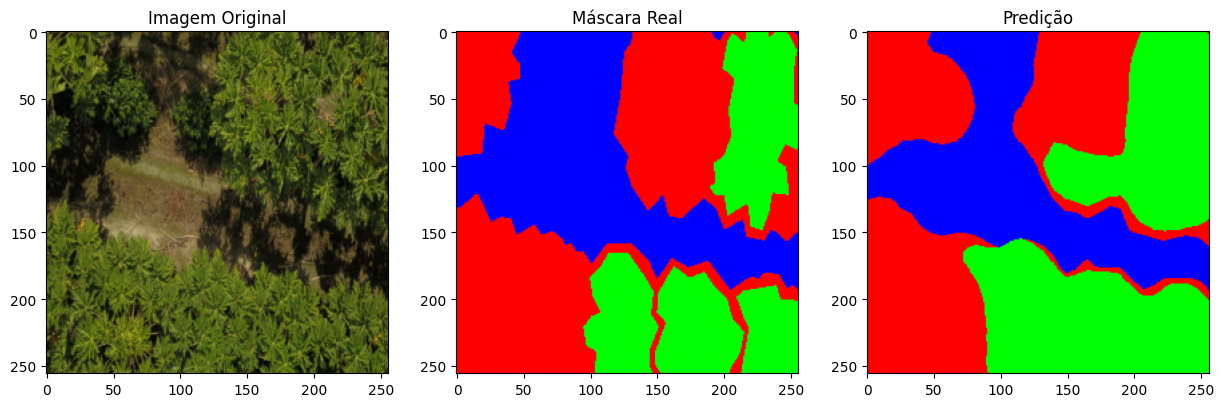

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


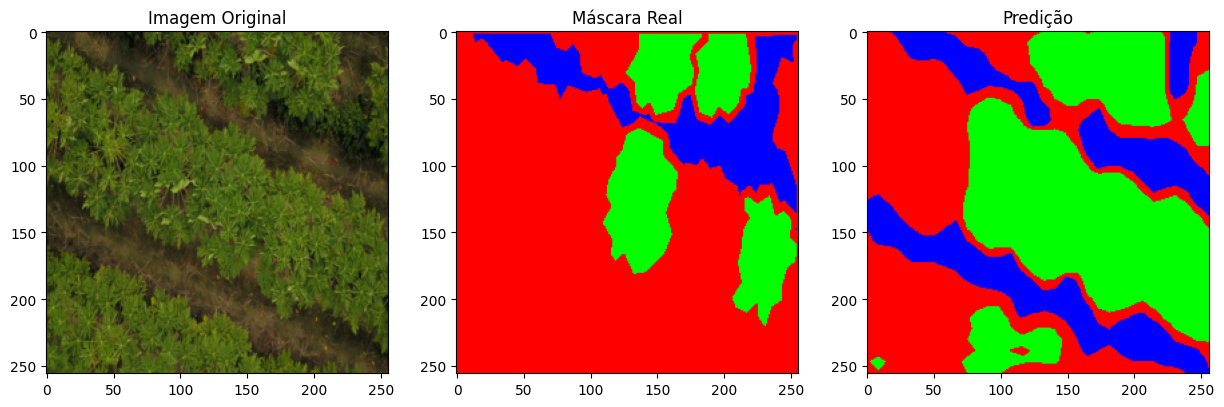

Visualização e salvamento concluídos!


In [37]:
import os

# Diretório para salvar os resultados
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results"
os.makedirs(results_dir, exist_ok=True)

# Função auxiliar para transformar índices de classe em cores RGB
def class_to_rgb(mask_indices):
    mask_rgb = np.zeros((mask_indices.shape[0], mask_indices.shape[1], 3), dtype=np.uint8)
    unique_classes = np.unique(mask_indices)
    print(f"Unique classes in mask: {unique_classes}")  # Log para classes únicas

    for class_index, color in enumerate(CLASS_COLORS.values()):
        mask_rgb[mask_indices == class_index] = color
        print(f"Mapping class {class_index} to color {color}")  # Log para mapeamento
    return mask_rgb

# Função para visualizar e salvar predições
def visualize_and_save_predictions(model, data_loader, device, results_dir, model_name, num_images=5):
    model.eval()
    images_saved = 0

    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                images_saved += 1
                if images_saved > num_images:
                    return
                
                # Processamento para visualização
                image = (inputs[i].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                
                # Conversão de índices para RGB
                mask = class_to_rgb(masks[i].cpu().numpy())
                prediction = class_to_rgb(preds[i].cpu().numpy())

                # Logs para depuração
                print(f"Input shape: {inputs[i].shape}")
                print(f"Mask shape: {masks[i].shape}")
                print(f"Prediction shape: {preds[i].shape}")

                # Visualização
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Imagem Original')

                plt.subplot(1, 3, 2)
                plt.imshow(mask)
                plt.title('Máscara Real')

                plt.subplot(1, 3, 3)
                plt.imshow(prediction)
                plt.title('Predição')

                plt.show()
                
                # Salvar as imagens
                plt.imsave(os.path.join(results_dir, f'{model_name}_input_{images_saved}.png'), image)
                plt.imsave(os.path.join(results_dir, f'{model_name}_mask_{images_saved}.png'), mask)
                plt.imsave(os.path.join(results_dir, f'{model_name}_prediction_{images_saved}.png'), prediction)

# Executar para cada modelo
for model_name, model in models.items():
    print(f"Visualizando e salvando predições para {model_name}...")
    
    trained_model = model
    trained_model.load_state_dict(torch.load(f'{model_name}_best.pth'))
    trained_model.to(device)
    
    visualize_and_save_predictions(trained_model, test_loader, device, results_dir, model_name, num_images=5)

print("Visualização e salvamento concluídos!")